In [1]:
import time

import numpy as np
import jax.numpy as jnp
import matplotlib.colors as colors

from vivarium.environments.braitenberg.selective_sensing.selective_sensing_env import SelectiveSensorsEnv, init_state
from vivarium.environments.braitenberg.render import render, render_history

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


## Init and launch a simulation

We define an environment with 4 types of entities, preys and predators as agents, and resources and poison as objects. The data of each entity type are defined in a dictionary specifying their type, their number and their color, as well as their behaviors if they are agents. Then all this data is aggregated in an entities data dictionary passed to a function to init the state of the simulation.

In [2]:
entities_subtypes = ['PREYS', 'PREDS', 'RESOURCES', 'POISON']

preys_data = {
    'type': 'AGENT',
    'num': 5,
    'color': 'blue',
    'selective_behaviors': {
        'love': {'beh': 'LOVE', 'sensed': ['PREYS', 'RESOURCES']},
        'fear': {'beh': 'FEAR', 'sensed': ['PREDS', 'POISON']}
    }}

preds_data = {
    'type': 'AGENT',
    'num': 5,
    'color': 'red',
    'selective_behaviors': {
        'aggr': {'beh': 'AGGRESSION','sensed': ['PREYS']},
        'fear': {'beh': 'FEAR','sensed': ['POISON']
        }
    }}

resources_data = {
    'type': 'OBJECT',
    'num': 5,
    'color': 'green'}

poison_data = {
    'type': 'OBJECT',
    'num': 5,
    'color': 'purple'}

entities_data = {
    'EntitySubTypes': entities_subtypes,
    'Entities': {
        'PREYS': preys_data,
        'PREDS': preds_data,
        'RESOURCES': resources_data,
        'POISON': poison_data
    }}

In [3]:
state = init_state(entities_data)
env = SelectiveSensorsEnv(state, occlusion=True)

In [4]:
max_agents = state.max_agents

def normal(array):
    normals = np.zeros((array.shape[0], 2))
    normals[:, 0] = np.cos(array)
    normals[:, 1] = np.sin(array)
    return normals

In [5]:
def initialize_agents_objects_data(
    agents_pos, agents_theta, agents_diameter, agents_colors, motors, proxs, max_prox, angle_min, wheel_diameter,
    objects_pos, objects_theta, objects_diameter, objects_colors
):
    x, y = agents_pos[:, 0], agents_pos[:, 1]
    radii = agents_diameter / 2.

    # line direction
    angles = np.array(agents_theta)
    normals = normal(angles)

    # wheels directions
    normals_rw = normal(angles + np.pi / 2)
    normals_lw = normal(angles - np.pi / 2)

    # proxs directions
    normals_rp = normal(angles + np.pi / 4)
    normals_lp = normal(angles - np.pi / 4)

    r_wheel_x, r_wheel_y, l_wheel_x, l_wheel_y = [], [], [], []
    r_prox_x, r_prox_y, l_prox_x, l_prox_y = [], [], [], []
    orientation_lines_x, orientation_lines_y = [], []

    for xx, yy, n, nrw, nlw, nrp, nlp, r in zip(x, y, normals, normals_rw, normals_lw, normals_rp, normals_lp, radii):
        r_wheel_x.append(xx + r * nrw[0])
        r_wheel_y.append(yy + r * nrw[1])
        l_wheel_x.append(xx + r * nlw[0])
        l_wheel_y.append(yy + r * nlw[1])

        r_prox_x.append(xx + r * nrp[0])
        r_prox_y.append(yy + r * nrp[1])
        l_prox_x.append(xx + r * nlp[0])
        l_prox_y.append(yy + r * nlp[1])

        orientation_lines_x.append([xx, xx + r * n[0]])
        orientation_lines_y.append([yy, yy + r * n[1]])

    max_angle_r = agents_theta - angle_min
    max_angle_l = agents_theta + angle_min

    agents_data = dict(
        x=x, y=y, ox=orientation_lines_x, oy=orientation_lines_y, r=radii, fc=agents_colors,
        angle=agents_theta, pr=0.2 * radii, rwx=r_wheel_x, rwy=r_wheel_y, lwx=l_wheel_x,
        lwy=l_wheel_y, rwi=motors[:, 0], lwi=motors[:, 1], rpx=r_prox_x,
        rpy=r_prox_y, lpx=l_prox_x, lpy=l_prox_y, rpi=proxs[:, 0],
        lpi=proxs[:, 1], mar=max_angle_r, mal=max_angle_l, mpr=max_prox,
        wd=wheel_diameter
    )

    objects_data = dict(
        x=objects_pos[:, 0], y=objects_pos[:, 1], width=objects_diameter, height=objects_diameter,
        angle=objects_theta, fill_color=objects_colors
    )

    return agents_data, objects_data

In [6]:
def state_to_bokeh_data(state):
    # Extract data from state
    exists_agents, exists_objects = state.entities.exists[:max_agents], state.entities.exists[max_agents:] 
    exists_agents = jnp.where(exists_agents != 0)
    exists_objects = jnp.where(exists_objects != 0)

    # Initialize agents and objects data
    agents_data, objects_data = initialize_agents_objects_data(
        agents_pos=state.entities.position.center[:max_agents][exists_agents],
        agents_theta=state.entities.position.orientation[:max_agents][exists_agents],
        agents_diameter=state.entities.diameter[:max_agents][exists_agents],
        agents_colors=[colors.to_hex(np.array(c)) for c in state.agents.color[exists_agents]],
        motors=state.agents.motor[exists_agents],
        proxs=state.agents.prox[exists_agents],
        max_prox=state.agents.proxs_dist_max[exists_agents],
        angle_min=np.arccos(state.agents.proxs_cos_min[exists_agents]),
        wheel_diameter=state.agents.wheel_diameter[exists_agents],
        objects_pos=state.entities.position.center[max_agents:][exists_objects],
        objects_theta=state.entities.position.orientation[max_agents:][exists_objects],
        objects_diameter=state.entities.diameter[max_agents:][exists_objects],
        objects_colors=[colors.to_hex(np.array(c)) for c in state.objects.color[exists_objects]]
    )

    return agents_data, objects_data

In [7]:
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource
from bokeh.io import output_notebook
import numpy as np

output_notebook()

def render_bokeh(box_size, agents_data, objects_data):
    p = figure(width=600, height=600, x_range=(0, box_size), y_range=(0, box_size), title="Simulation State")
    p.xaxis.axis_label = "X Position"
    p.yaxis.axis_label = "Y Position"

    # Create ColumnDataSource for agents
    agents_source = ColumnDataSource(data=agents_data)
    objects_source = ColumnDataSource(data=objects_data)

    # Plot agents
    p.rect('rwx', 'rwy', width='wd', height=1, angle='angle', fill_color='black', fill_alpha='rwi', line_color=None, source=agents_source)
    p.rect('lwx', 'lwy', width='wd', height=1, angle='angle', fill_color='black', fill_alpha='lwi', line_color=None, source=agents_source)
    p.circle('rpx', 'rpy', radius='pr', fill_color='red', fill_alpha='rpi', line_color=None, source=agents_source)
    p.circle('lpx', 'lpy', radius='pr', fill_color='red', fill_alpha='lpi', line_color=None, source=agents_source)
    p.wedge('x', 'y', radius='mpr', start_angle='angle', end_angle='mar', color="firebrick", alpha=0.1, direction="clock", source=agents_source)
    p.wedge('x', 'y', radius='mpr', start_angle='angle', end_angle='mal', color="firebrick", alpha=0.1, direction="anticlock", source=agents_source)
    p.multi_line('ox', 'oy', color='black', source=agents_source)
    p.circle('x', 'y', radius='r', fill_color='fc', fill_alpha=0.6, line_color=None, hover_fill_color="black", hover_fill_alpha=0.7, hover_line_color=None, source=agents_source)

    # Plot objects
    p.rect(x='x', y='y', width='width', height='height', angle='angle', fill_color='fill_color', fill_alpha=0.6, line_color=None, hover_fill_color="black", hover_fill_alpha=0.7, hover_line_color=None, source=objects_source)

    return p

Loading BokehJS ...

In [8]:
box_size = state.box_size
agents_data, objects_data = state_to_bokeh_data(state)

In [9]:
p = render_bokeh(box_size, agents_data, objects_data)
show(p)

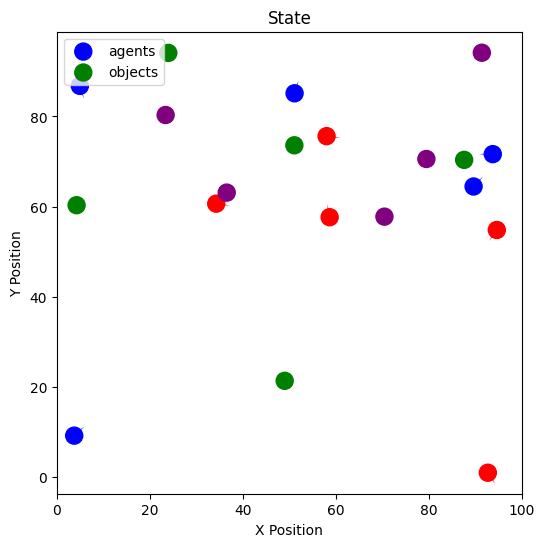

In [10]:
render(state)

# TODO : Add bokeh rendering video

In [11]:
n_steps = 5_000
hist = []

for i in range(n_steps):
    state = env.step(state)
    hist.append(state)

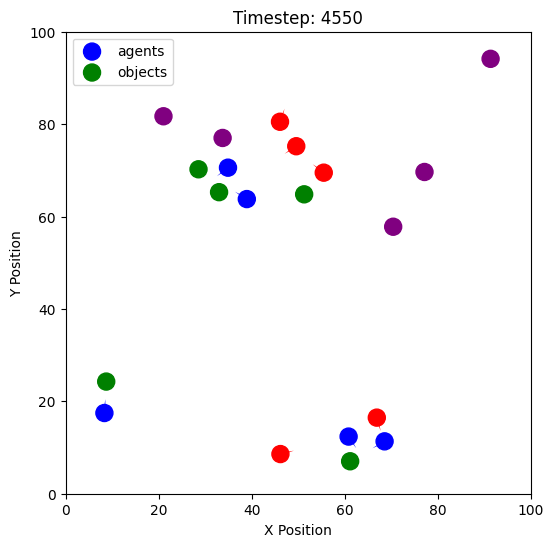

In [ ]:
render_history(hist, skip_frames=50)